In [1]:
import pandas as pd
import email

In [2]:
emails_df = pd.read_csv('emails.csv', nrows=10000) 

def parse_raw_message(raw_message):
    msg = email.message_from_string(raw_message)
    email_to = msg.get('To')
    email_from = msg.get('From')
    email_body = msg.get_payload()
    return email_from, email_to, email_body

parsed_data = emails_df['message'].apply(parse_raw_message)

df_clean = pd.DataFrame(parsed_data.tolist(), columns=['From', 'To', 'Body'])
df_clean.dropna(inplace=True)

df_clean['To'] = df_clean['To'].str.replace('\n', '').str.replace('\t', '')
df_clean = df_clean.assign(To=df_clean['To'].str.split(',')).explode('To')

df_clean['From'] = df_clean['From'].str.strip()
df_clean['To'] = df_clean['To'].str.strip()

print(f"Data parsed! Rows: {len(df_clean)}")
print(df_clean.head())

Data parsed! Rows: 31367
                      From                       To  \
0  phillip.allen@enron.com     tim.belden@enron.com   
1  phillip.allen@enron.com  john.lavorato@enron.com   
2  phillip.allen@enron.com   leah.arsdall@enron.com   
3  phillip.allen@enron.com    randall.gay@enron.com   
4  phillip.allen@enron.com     greg.piper@enron.com   

                                                Body  
0                          Here is our forecast\n\n   
1  Traveling to have a business meeting takes the...  
2                     test successful.  way to go!!!  
3  Randy,\n\n Can you send me a schedule of the s...  
4                Let's shoot for Tuesday at 11:45.    


In [3]:
import networkx as nx

G = nx.from_pandas_edgelist(df_clean, source='From', target='To', create_using=nx.DiGraph())

print(f"Nodes: {G.number_of_nodes()}, Edges: {G.number_of_edges()}")


in_degree = nx.in_degree_centrality(G)
out_degree = nx.out_degree_centrality(G)
betweenness = nx.betweenness_centrality(G, k=100) 

network_features = pd.DataFrame({
    'in_degree': pd.Series(in_degree),
    'out_degree': pd.Series(out_degree),
    'betweenness': pd.Series(betweenness)
}).fillna(0)

print("Network features ready!")
print(network_features.head())

Nodes: 3959, Edges: 7914
Network features ready!
                         in_degree  out_degree  betweenness
phillip.allen@enron.com   0.004295    0.050278     0.013117
tim.belden@enron.com      0.006316    0.004800     0.000605
john.lavorato@enron.com   0.005306    0.013138     0.006955
leah.arsdall@enron.com    0.000253    0.000000     0.000000
randall.gay@enron.com     0.000505    0.000000     0.000000


In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer

sender_text = df_clean.groupby('From')['Body'].apply(lambda x: ' '.join(x)).reset_index()

tfidf = TfidfVectorizer(stop_words='english', max_features=100)

text_features_matrix = tfidf.fit_transform(sender_text['Body'])

text_features_df = pd.DataFrame(
    text_features_matrix.toarray(), 
    index=sender_text['From']
)

text_features_df.columns = [f"word_{i}" for i in range(text_features_df.shape[1])]

print("NLP Features ready!")

NLP Features ready!


In [7]:
from sklearn.ensemble import IsolationForest

full_data = network_features.join(text_features_df, how='inner')
iso_forest = IsolationForest(n_estimators=100, contamination=0.01, random_state=42)

iso_forest.fit(full_data)

full_data['anomaly_score'] = iso_forest.decision_function(full_data)
full_data['prediction'] = iso_forest.predict(full_data.drop(columns=['anomaly_score']))

suspicious_nodes = full_data[full_data['prediction'] == -1]

print(f"Detected {len(suspicious_nodes)} suspicious nodes.")
print(suspicious_nodes[['in_degree', 'out_degree', 'anomaly_score']].head())

Detected 8 suspicious nodes.
                            in_degree  out_degree  anomaly_score
ina.rangel@enron.com         0.003032    0.023497      -0.043496
savita.puthigai@enron.com    0.000505    0.002274      -0.008759
technology.enron@enron.com   0.000000    0.088176      -0.025001
jae.black@enron.com          0.001263    0.030066      -0.036320
bob.ambrocik@enron.com       0.000253    0.200859      -0.053878


C:\Users\souri\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


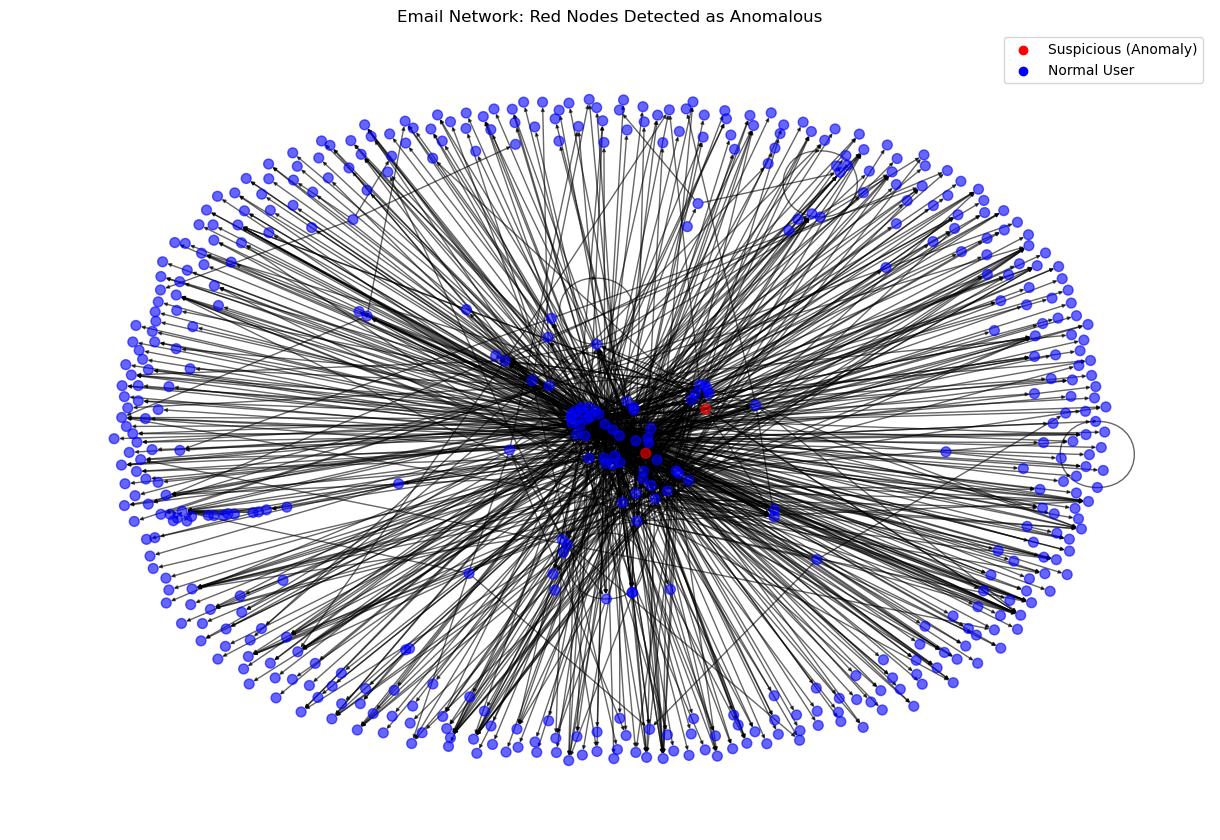

In [8]:
import matplotlib.pyplot as plt

subgraph_nodes = list(G.nodes())[:500] 
sub_G = G.subgraph(subgraph_nodes)

pos = nx.spring_layout(sub_G, seed=42)

node_colors = []
for node in sub_G.nodes():
    if node in suspicious_nodes.index:
        node_colors.append('red') # Malicious
    else:
        node_colors.append('blue') # Normal

plt.figure(figsize=(12, 8))
nx.draw(sub_G, pos, 
        node_color=node_colors, 
        node_size=50, 
        alpha=0.6, 
        with_labels= , 
        arrowsize=5)

plt.scatter([], [], c='red', label='Suspicious (Anomaly)')
plt.scatter([], [], c='blue', label='Normal User')
plt.legend()
plt.title("Email Network: Red Nodes Detected as Anomalous")
plt.show()

In [3]:
import pandas as pd
import os

MAIN_FILE = 'emails.csv'
TEST_SPLIT_FILE = 'emails_test.csv'
TEST_SIZE = 100000 

if not os.path.exists(MAIN_FILE):
    print("error")
else:
    if os.path.exists(TEST_SPLIT_FILE):
        print("file already exist.")
    else:
        print("loading")
        
        try:
            df_full = pd.read_csv(MAIN_FILE)
            
            if len(df_full) < TEST_SIZE * 2:
                TEST_SIZE = len(df_full) // 5 
            df_test = df_full.tail(TEST_SIZE)
            ile
            df_test.to_csv(TEST_SPLIT_FILE, index=False)
            
            print("created")
            
        except Exception as e:
            print("error")

file already exist.


C:\Users\souri\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


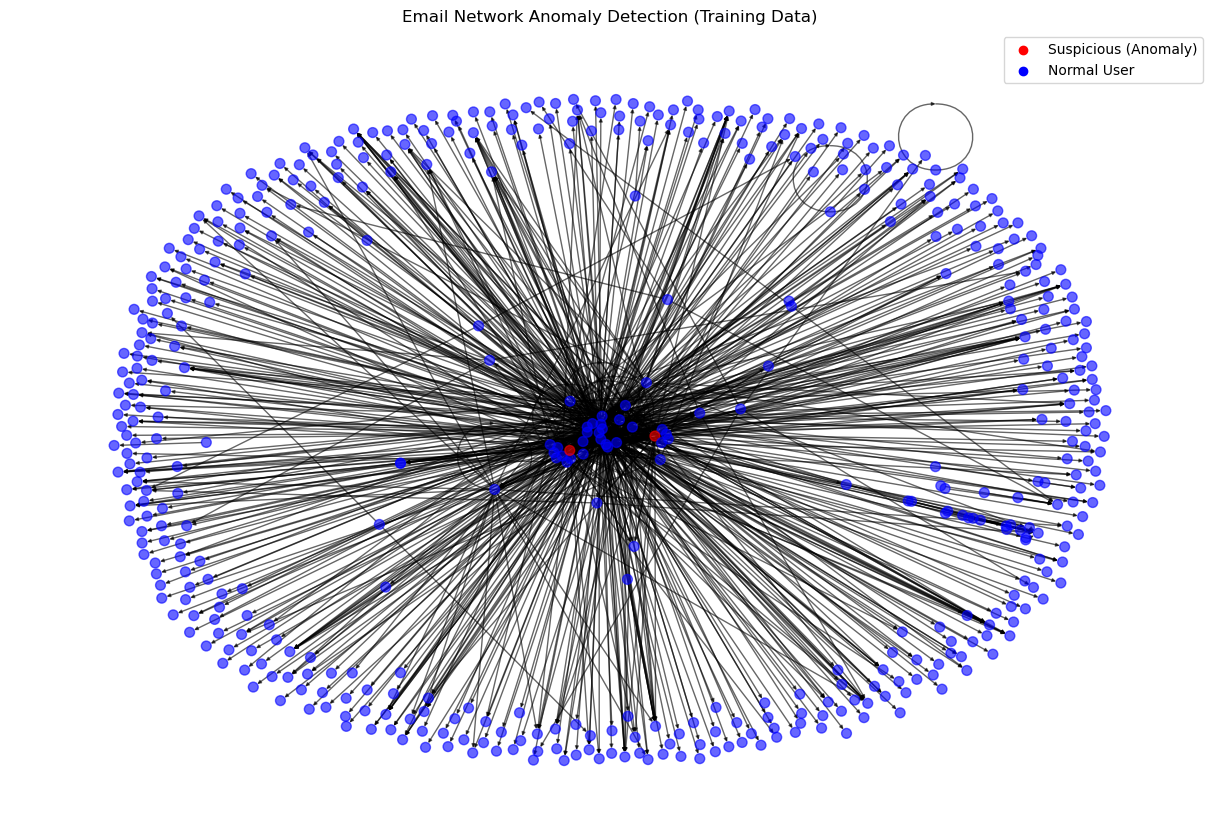

Total Suspicious Nodes Detected (Training Data): 3

--- Validation Scores (against Simulated True Labels) ---
Precision (Malicious Class): 0.0000
Recall (Malicious Class): 0.0000
F1 Score (Harmonic Mean): 0.0000

Confusion Matrix (True vs Predicted):
 [[  0   0]
 [ 10 549]]


C:\Users\souri\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
C:\Users\souri\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [5]:
import pandas as pd
import networkx as nx
import email
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import IsolationForest
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

NROWS = 5000 
TRAIN_FILE = 'emails.csv'
TEST_FILE = 'emails_test.csv'

def parse_raw_message(raw_message):
    msg = email.message_from_string(raw_message)
    return msg.get('From'), msg.get('To'), msg.get_payload()

def process_data(file_path):
    df_raw = pd.read_csv(file_path, nrows=NROWS)
    parsed_data = df_raw['message'].apply(parse_raw_message)
    df_clean = pd.DataFrame(parsed_data.tolist(), columns=['From', 'To', 'Body']).dropna()
    df_clean['To'] = df_clean['To'].str.replace('\n', '').str.replace('\t', '')
    df_clean = df_clean.assign(To=df_clean['To'].str.split(',')).explode('To')
    df_clean['From'] = df_clean['From'].str.strip()
    df_clean['To'] = df_clean['To'].str.strip()
    return df_clean

def get_features(df_clean, tfidf_fit=True, tfidf_model=None):
    G = nx.from_pandas_edgelist(df_clean, source='From', target='To', create_using=nx.DiGraph())
    in_degree = nx.in_degree_centrality(G)
    out_degree = nx.out_degree_centrality(G)
    betweenness = nx.betweenness_centrality(G, k=50) 
    
    network_features = pd.DataFrame({'in_degree': pd.Series(in_degree),
                                     'out_degree': pd.Series(out_degree),
                                     'betweenness': pd.Series(betweenness)}).fillna(0)

    sender_text = df_clean.groupby('From')['Body'].apply(lambda x: ' '.join(x)).reset_index()
    
    if tfidf_fit:
        tfidf = TfidfVectorizer(stop_words='english', max_features=100)
        text_features_matrix = tfidf.fit_transform(sender_text['Body'])
    else:
        text_features_matrix = tfidf_model.transform(sender_text['Body'])
        tfidf = tfidf_model

    text_features_df = pd.DataFrame(text_features_matrix.toarray(), index=sender_text['From'])
    text_features_df.columns = [f"word_{i}" for i in range(text_features_df.shape[1])]
    
    full_data = network_features.join(text_features_df, how='inner')
    
    return full_data, G, tfidf

df_train = process_data(TRAIN_FILE)
full_data_train, G_train, tfidf_model = get_features(df_train, tfidf_fit=True)

iso_forest = IsolationForest(n_estimators=100, contamination=0.01, random_state=42)
iso_forest.fit(full_data_train)

full_data_train['prediction'] = iso_forest.predict(full_data_train)
suspicious_nodes = full_data_train[full_data_train['prediction'] == -1]

subgraph_nodes = list(G_train.nodes())[:500] 
sub_G = G_train.subgraph(subgraph_nodes)
pos = nx.spring_layout(sub_G, seed=42)

node_colors = ['red' if node in suspicious_nodes.index else 'blue' for node in sub_G.nodes()]

plt.figure(figsize=(12, 8))
nx.draw(sub_G, pos, node_color=node_colors, node_size=50, alpha=0.6, with_labels=False, arrowsize=5)
plt.scatter([], [], c='red', label='Suspicious (Anomaly)')
plt.scatter([], [], c='blue', label='Normal User')
plt.title("Email Network Anomaly Detection (Training Data)")
plt.legend()
plt.show()

df_test = process_data(TEST_FILE)
full_data_test, G_test, _ = get_features(df_test, tfidf_fit=False, tfidf_model=tfidf_model)

top_out_degree_threshold = full_data_test['out_degree'].quantile(0.999) 
median_in_degree_threshold = full_data_test['in_degree'].quantile(0.5)

Y_Test_True_IF = full_data_test.apply(
    lambda row: -1 if (row['out_degree'] >= top_out_degree_threshold) and 
                       (row['in_degree'] < median_in_degree_threshold) 
                 else 1, axis=1
)

X_test = full_data_test.values
Y_Test_Pred = iso_forest.predict(X_test)

precision = precision_score(Y_Test_True_IF, Y_Test_Pred, pos_label=-1) 
recall = recall_score(Y_Test_True_IF, Y_Test_Pred, pos_label=-1)
f1 = f1_score(Y_Test_True_IF, Y_Test_Pred, pos_label=-1) 
cm = confusion_matrix(Y_Test_True_IF, Y_Test_Pred)

print(f"Total Suspicious Nodes Detected (Training Data): {len(suspicious_nodes)}")
print("\n--- Validation Scores (against Simulated True Labels) ---")
print(f"Precision (Malicious Class): {precision:.4f}")
print(f"Recall (Malicious Class): {recall:.4f}")
print(f"F1 Score (Harmonic Mean): {f1:.4f}")
print()
print("Confusion Matrix (True vs Predicted):\n", cm)